# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [24]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [26]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

In [27]:
df['balance']=df['balance'].apply(lambda x: str(x).replace(" ", ""))
df['balance']=df['balance'].apply(lambda x: str(x).replace("$", ""))
df['balance']=df['balance'].apply(lambda x: str(x).replace(",00", ""))

In [31]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance']=df['balance'].astype('float')

In [33]:
df['balance'].mean()

1529.1290293615875

### Задание 4

In [36]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df.loc[(df['balance'].isnull()==True),'balance']=df['balance'].median() # ваш код здесь  

In [37]:
df['balance'].mean()

1526.9360329690019

### Задание 5

In [44]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
job_mode=df['job'].mode()[0]
edu_mode=df['education'].mode()[0]
df['job']=df['job'].apply(lambda x: x.replace("unknown", job_mode))
df['education']=df['education'].apply(lambda x: x.replace("unknown", edu_mode))

In [53]:
df[(df['job']=="management") & (df['education']=="secondary")]['balance'].mean()

1598.8829787234042

### Задание 6

In [54]:
# удалите все выбросы для признака balance
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

In [55]:
outliers, cleaned, lower_bound, upper_bound = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print(f'Нижняя граница: {lower_bound}')
print(f'Верхняя граница: {upper_bound}')

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105
Нижняя граница: -2241.0
Верхняя граница: 4063.0


## Часть 2:  Разведывательный анализ

### Задание 1

In [59]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
cleaned['deposit'].value_counts()

deposit
no     5424
yes    4681
Name: count, dtype: int64

### Задания 2 и 3

In [63]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
print(cleaned['age'].max())
print(cleaned['duration'].min())

95
2


### Задания 4 и 5

In [64]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
cleaned.describe(include = 'object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


### Задание 6

In [78]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
cleaned[cleaned['poutcome'] =='failure'].groupby(by='poutcome')['campaign'].value_counts()

poutcome  campaign
failure   1           566
          2           313
          3           126
          4            53
          5            27
          6             9
          7             8
          8             5
          9             1
          12            1
Name: count, dtype: int64

### Задание 7

In [79]:
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


In [80]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
cleaned.groupby(by='poutcome')['month'].value_counts()

poutcome  month
failure   may       335
          apr       150
          nov       139
          feb       127
          aug        84
          oct        62
          jun        48
          sep        46
          jul        42
          jan        39
          mar        26
          dec        11
other     may       113
          apr        64
          feb        55
          nov        40
          jan        36
          aug        36
          sep        31
          jun        28
          jul        26
          mar        20
          oct        20
          dec        12
success   aug       137
          may       117
          feb        93
          sep        91
          oct        90
          nov        85
          jun        84
          apr        77
          jul        64
          mar        42
          jan        37
          dec        28
unknown   may      2052
          jul      1286
          aug      1128
          jun       944
          apr       539


In [81]:
cleaned

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [85]:
cleaned.groupby(by='new_age')['deposit'].value_counts()

new_age  deposit
30-40    no         2245
         yes        1716
40-50    no         1444
         yes         938
50-60    no          984
         yes         670
60+      yes         496
         no          157
<30      yes         861
         no          594
Name: count, dtype: int64

### Задание 8

In [83]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def new_age(age):
    if age <30:
        return '<30'
    elif age < 40:
        return '30-40'
    elif age < 50:
        return '40-50'
    elif age < 60:
        return '50-60'
    else:
        return '60+'

In [84]:
cleaned['new_age'] = cleaned['age'].apply(new_age)
cleaned

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,new_age
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-60
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no,30-40
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no,30-40
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no,30-40
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no,40-50


### Задания 9 и 10

In [86]:
cleaned['job'].value_counts()

job
management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: count, dtype: int64

In [87]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
cleaned.groupby(by='marital')['deposit'].value_counts()

marital   deposit
divorced  no          624
          yes         553
married   no         3303
          yes        2412
single    yes        1716
          no         1497
Name: count, dtype: int64

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости


### Задание 11

In [88]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
cleaned.groupby(['education', 'marital'])['deposit'].value_counts()

education  marital   deposit
primary    divorced  yes          96
                     no           91
           married   no          641
                     yes         339
           single    no          100
                     yes          82
secondary  divorced  no          370
                     yes         283
           married   no         1830
                     yes        1289
           single    yes         879
                     no          866
tertiary   divorced  yes         174
                     no          163
           married   no          832
                     yes         784
           single    yes         755
                     no          531
Name: count, dtype: int64

## Часть 3: преобразование данных

### Задание 1

In [ ]:
# преобразуйте уровни образования
LE=LabelEncoder()
cleaned['education'] = LE.fit_transform(cleaned['education'])

In [91]:
cleaned['education'].sum()

11995

In [92]:
cleaned['new_age'] = LE.fit_transform(cleaned['new_age'])

### Задания 2 и 3

In [94]:
# преобразуйте бинарные переменные в представление из нулей и единиц
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
cleaned['deposit'] = lb.fit_transform(cleaned['deposit'])

In [96]:
cleaned['deposit'].std()

0.4986712532452124

In [97]:
cleaned['default'] = lb.fit_transform(cleaned['default'])
cleaned['housing'] = lb.fit_transform(cleaned['housing'])
cleaned['loan'] = lb.fit_transform(cleaned['loan'])

In [99]:
cleaned['default'].mean() + cleaned['housing'].mean() + cleaned['loan'].mean()

0.6354280059376547

### Задание 4

In [103]:
# создайте дамми-переменные
cleaned = pd.get_dummies(cleaned, columns=['job', 'marital', 'contact', 'month', 'poutcome'])

In [108]:
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int64  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  new_age            10105 non-null  int64  
 13  job_admin.         10105 non-null  bool   
 14  job_blue-collar    10105 non-null  bool   
 15  job_entrepreneur   10105 non-null  bool   
 16  job_housemaid      10105 no

### Задания 5 и 6

<Axes: >

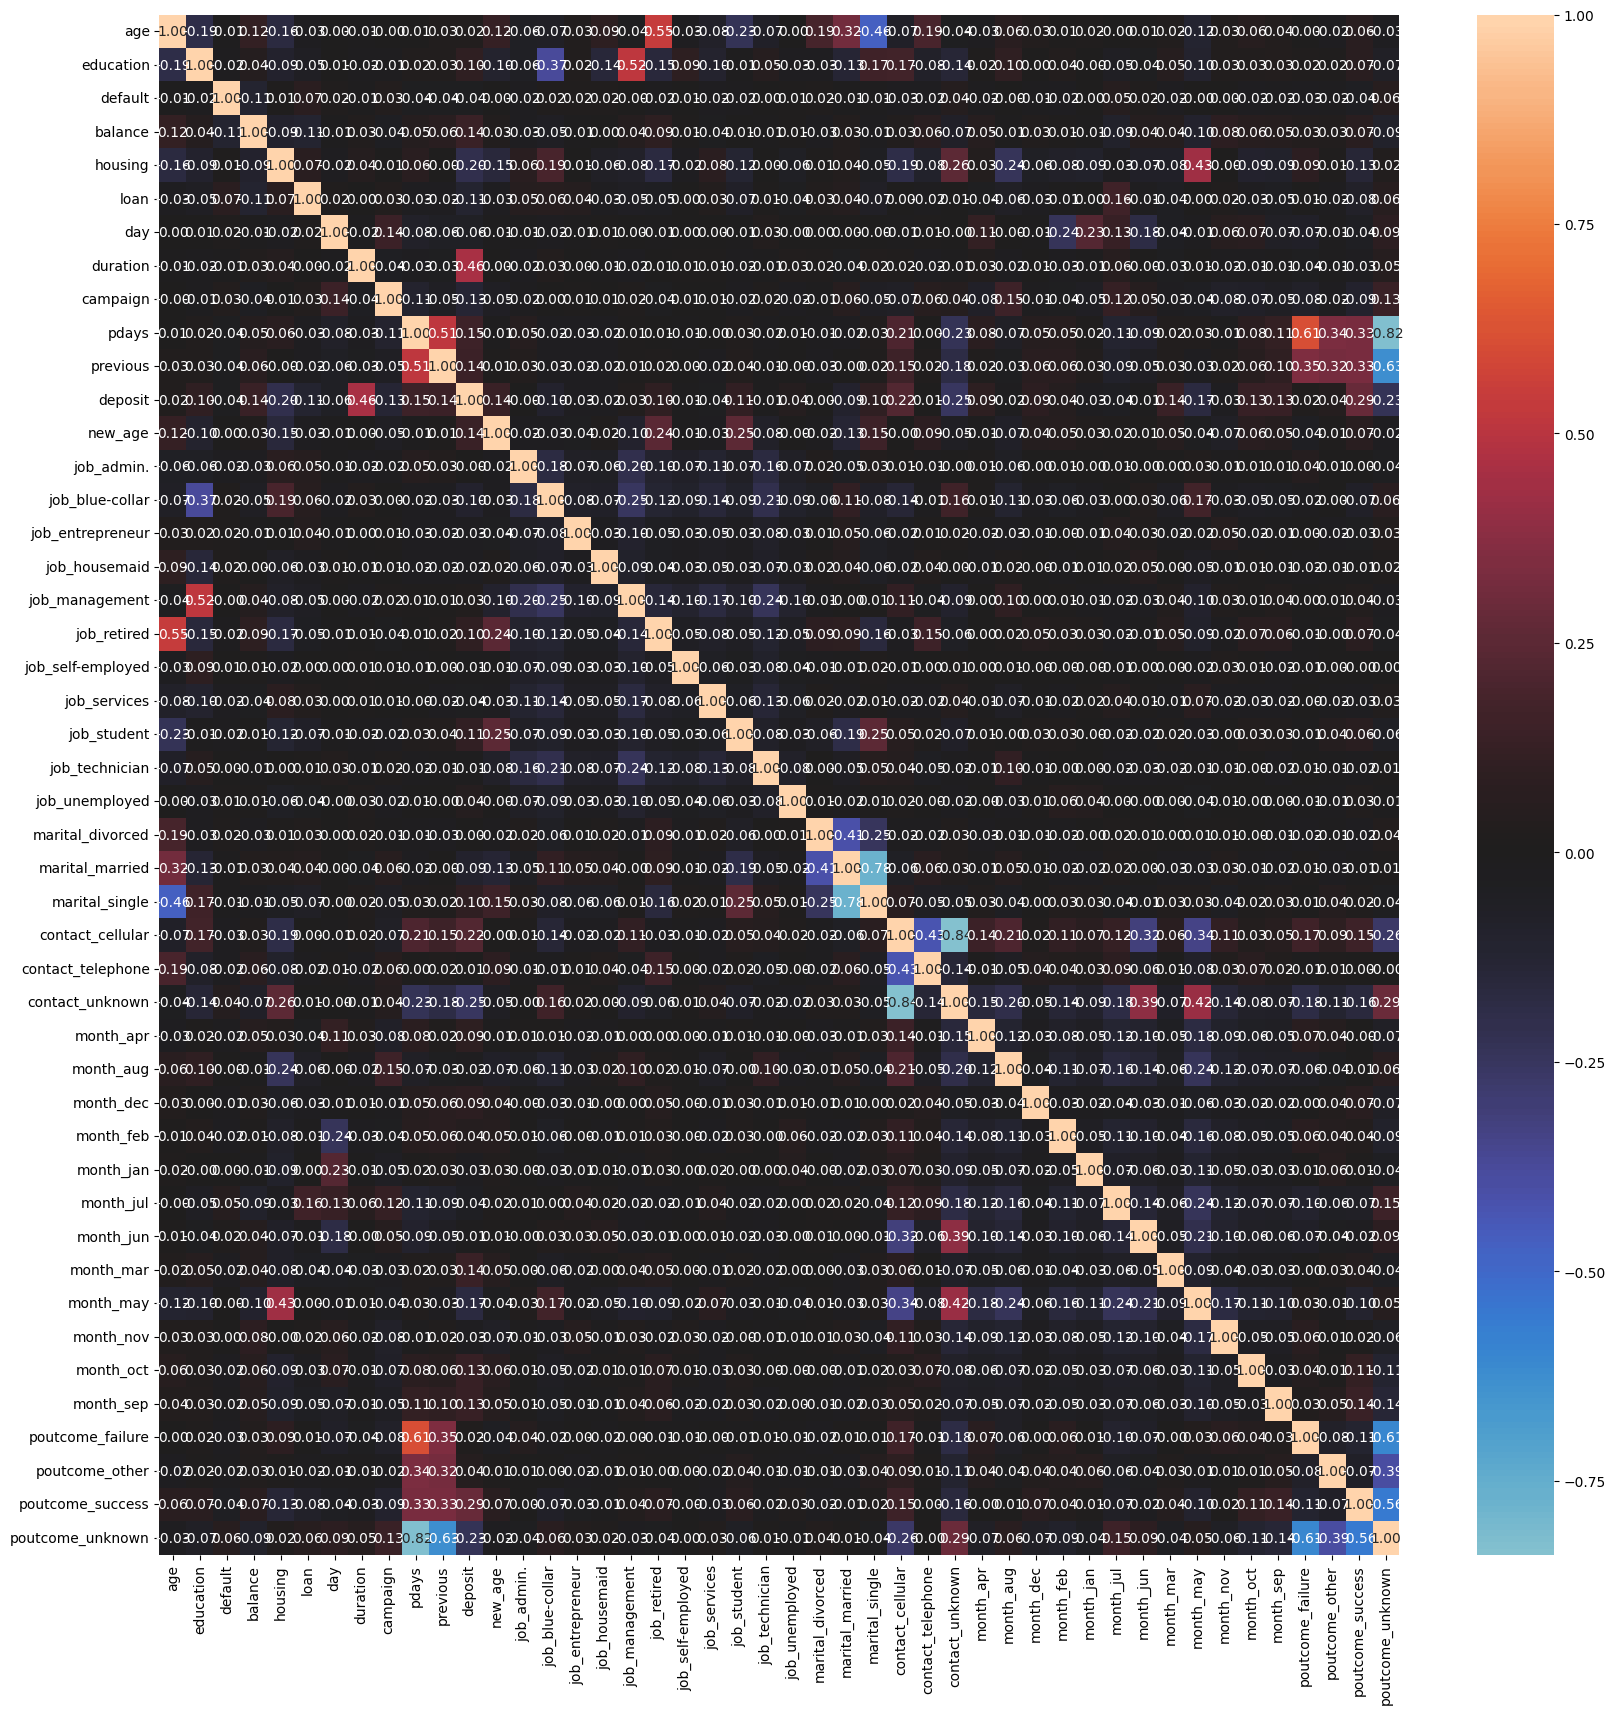

In [109]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.figure(figsize=(20,20))  
sns.heatmap(cleaned.corr(numeric_only=True),fmt='.2f',annot=True, center=0)

### Задания 7 и 8

In [110]:
df = cleaned

In [112]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [118]:
# рассчитайте необходимые показатели
y_test.mean()

0.46326836581709147

### Задание 9

In [119]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(score_func = f_classif, k=15)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'new_age', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

### Задание 10

In [131]:
col_names = ['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'new_age', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown']
X_train_new = X_train[col_names]
X_test_new = X_test[col_names]

In [132]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
 
scaler.fit(X_train_new)
X_train_new_scaled = scaler.transform(X_train_new)

scaler.fit(X_test_new)
X_test_new_scaled = scaler.transform(X_test_new)

In [133]:
print(X_test_new_scaled[:,0].mean())

0.45901814327601437


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [136]:
# обучите логистическую регрессию и рассчитайте метрики качества
#Создаём объект класса LogisticRegression
log_reg = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
#Обучаем модель
log_reg.fit(X_train_new_scaled, y_train)

#Делаем предсказание класса
y_pred = log_reg.predict(X_test_new_scaled)

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1790
           1       0.79      0.81      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задания 2,3,4

In [137]:
# обучите решающие деревья, настройте максимальную глубину
#Создаём объект класса DecisionTreeClassifier
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', 
    random_state=42
)
#Обучаем дерево решений по алгоритму CART
dt_clf.fit(X_train_new_scaled, y_train)

#Делаем предсказание класса для всего набора данных
y_pred = dt_clf.predict(X_test_new_scaled)
#Выводим отчёт о метриках классификации
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1790
           1       0.71      0.75      0.73      1545

    accuracy                           0.74      3335
   macro avg       0.74      0.74      0.74      3335
weighted avg       0.74      0.74      0.74      3335



In [139]:
#Делаем предсказание класса для всего набора данных
y_pred_train = dt_clf.predict(X_train_new_scaled)
#Выводим отчёт о метриках классификации
print(metrics.classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770



На тренировочной выборке получили идеальные метрики, значит модель переобучена

### Задание 5

In [148]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
#param_grid = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
#              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
#              'criterion':['entropy','gini']
#              }

param_grid = {'max_depth': list(np.linspace(1, 30, 50, dtype=int))}
            
grid_search_tree = GridSearchCV(estimator=tree.DecisionTreeClassifier(random_state=42, criterion='entropy'), param_grid=param_grid, cv=5, n_jobs=-1)
%time grid_search_tree.fit(X_train_new_scaled, y_train) 
print("accuracy на обучающем наборе: {:.2f}".format(grid_search_tree.score(X_train_new_scaled, y_train)))
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test_new_scaled, y_test)))
#y_test_pred = grid_search_tree.predict(X_test_scaled)
#print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

CPU times: user 472 ms, sys: 80.9 ms, total: 553 ms
Wall time: 5.38 s
accuracy на обучающем наборе: 0.85
accuracy на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 9}


In [153]:
param_grid = {'min_samples_split': [2, 5, 7, 20],
              'max_depth': [3, 5, 7],
              }
grid_search_tree = GridSearchCV(estimator=tree.DecisionTreeClassifier(random_state=42, criterion='entropy'), param_grid=param_grid, cv=5, n_jobs=-1)
%time grid_search_tree.fit(X_train_new_scaled, y_train) 

y_pred = grid_search_tree.predict(X_test_new_scaled)
#Выводим отчёт о метриках классификации
print(metrics.classification_report(y_test, y_pred))

CPU times: user 164 ms, sys: 22.8 ms, total: 186 ms
Wall time: 1.06 s
              precision    recall  f1-score   support

           0       0.87      0.76      0.81      1790
           1       0.76      0.87      0.81      1545

    accuracy                           0.81      3335
   macro avg       0.82      0.82      0.81      3335
weighted avg       0.82      0.81      0.81      3335



In [152]:
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 20}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [155]:
# обучите на ваших данных случайный лес
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    random_state=42, 
    n_estimators=100, 
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10
    )

#Обучаем модель
rf.fit(X_train_new_scaled, y_train)

y_pred_train = rf.predict(X_train_new_scaled)
y_pred_test = rf.predict(X_test_new_scaled)

#Выводим отчёт о метриках классификации
print(metrics.classification_report(y_train, y_pred_train))
print(metrics.classification_report(y_test, y_pred_test))



              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3634
           1       0.84      0.86      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

              precision    recall  f1-score   support

           0       0.88      0.76      0.81      1790
           1       0.76      0.89      0.82      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



### Задания 2 и 3

In [160]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = ensemble.GradientBoostingRegressor(
    random_state=42, 
    n_estimators=300, 
    learning_rate=0.05,
    min_samples_leaf=5,
    max_depth=5
    )
#Обучаем модель
gb.fit(X_train_new_scaled, y_train)

y_pred_train = gb.predict(X_train_new_scaled)
y_pred_test = gb.predict(X_test_new_scaled)

#Выводим отчёт о метриках классификации
print(metrics.classification_report(y_train, y_pred_train))
print(metrics.classification_report(y_test, y_pred_test))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

### Задание 4

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna